
本人主要方向是深度学习技术在媒体、教育上的应用。欢迎深度学习赛道上的新老司机们关注交流，以后还会为大家分享更多有趣的项目。

【下面是我的主页链接】

来AI Studio互粉吧~等你哦~ [https://aistudio.baidu.com/aistudio/personalcenter/thirdview/76563](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/76563)

【项目列表】

[训练数据太少？过拟合？一文带你领略“数据增长魔法”(上) (https://aistudio.baidu.com/aistudio/projectdetail/408059)](https://aistudio.baidu.com/aistudio/projectdetail/408059)

[训练数据太少？过拟合？一文带你领略“数据增长魔法”(下) (https://aistudio.baidu.com/aistudio/projectdetail/422256)](https://aistudio.baidu.com/aistudio/projectdetail/422256)

[一文帮你理解用Paddle训练模型的原理1-手写回归模型 (https://aistudio.baidu.com/aistudio/projectdetail/367090)](https://aistudio.baidu.com/aistudio/projectdetail/367090)

[一文帮你理解用Paddle训练模型的原理2-权值可视化（VisualDL） (https://aistudio.baidu.com/aistudio/projectdetail/386954)](https://aistudio.baidu.com/aistudio/projectdetail/386954)



# 四、上回没讲完的故事
在上文《[训练数据太少？过拟合？一文带你领略“数据增长魔法”(上)](https://aistudio.baidu.com/aistudio/projectdetail/408059)》中我们已经使用了明暗、对比度、饱和度、锐化、 裁切、翻转、旋转、和加噪等各种“争奇斗艳”的图像数据増广技术治好了模型的过拟合。这样，应该就可以 live happily ever after了吧。现实中，如果我们继续训练模型至500epoch，loss曲线就又长成了“这样儿”...

![](https://ai-studio-static-online.cdn.bcebos.com/af2de78230c9413e8010bcbba2567ae9cb14b6c678d54a19ad3c18fc7a883b5d)

真是“我待模型如初恋，她虐我一遍又一遍”。要想继续提高模型精度，上次那几招已经被“过拟合”给看破了。接下来怎么办？

这次的方法是在使用上文介绍的数据増广方法的基础上使用的。所以，我们把上文中使用用户自定义数据増广方法（使用imgaug库效果也是同样的）的模型作为基线版本用于对比。我们先做好准备工作。

In [1]:
# 解压数据集（项目准备工作）
# 初次运行时需要将下面一行注释取消
#!unzip -d /home/aistudio/work /home/aistudio/data/data22612/Images.zip

In [2]:
#简单的数据増广（用作基线版本）
import numpy as np
import random
from PIL import Image, ImageEnhance
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# 随机改变亮度
def random_brightness(img, lower=0.5, upper=1.5):
    e = np.random.uniform(lower, upper)
    return ImageEnhance.Brightness(img).enhance(e)

# 随机改变对比度
def random_contrast(img, lower=0.5, upper=1.5):
    e = np.random.uniform(lower, upper)
    return ImageEnhance.Contrast(img).enhance(e)

# 随机改变颜色(饱和度)
def random_color(img, lower=0.5, upper=1.5):
    e = np.random.uniform(lower, upper)
    return ImageEnhance.Color(img).enhance(e)

# 随机改变清晰度
def random_sharpness(img, lower=0.5, upper=1.5):
    e = np.random.uniform(lower, upper)
    return ImageEnhance.Sharpness(img).enhance(e)

# 等比例随机裁剪
def random_crop(img, max_ratio=1.5):
    #if(random.random() > 0.5):
    #    return img
    img = np.asarray(img)
    h, w, _ = img.shape
    m = random.uniform(1, max_ratio)
    n = random.uniform(1, max_ratio)
    x1 = w * (1 - 1 / m) / 2
    y1 = h * (1 - 1 / n) / 2
    x2 = x1 + w * 1 / m
    y2 = y1 + h * 1 / n
    img = Image.fromarray(img)
    img = img.crop([x1, y1, x2, y2])
    type = [Image.NEAREST,Image.BILINEAR,Image.BICUBIC,Image.ANTIALIAS]
    img = img.resize((w, h),type[random.randint(0,3)])
    return img

# 随机翻转
def random_flip(img, thresh=0.5):
    img = np.asarray(img)
    if random.random() > thresh:
        img = img[:, ::-1, :]
    if random.random() > thresh:
        img = img[::-1 , :, :]
    img = Image.fromarray(img)
    return img

# 随机旋转图像
def random_rotate(img, thresh=0.5):
    # 任意角度旋转
    angle = np.random.randint(0, 360)
    img = img.rotate(angle)
    return img

# 随机加高斯噪声
def random_noise(img, max_sigma = 5, thresh=0.5):
    if random.random() > thresh:
        return img
    img = np.asarray(img)
    sigma = np.random.uniform(0, max_sigma)
    noise = np.round(np.random.randn(img.shape[0], img.shape[1], 3) * sigma).astype('uint8')
    img = img + noise
    img[img > 255] = 255
    img[img < 0] = 0
    img = Image.fromarray(img)
    return img

#统一使用各种图像増广方法
def image_augment(img):
    ops = [random_brightness, random_contrast, random_color, random_sharpness, random_crop, \
            random_flip, random_rotate, random_noise]
    np.random.shuffle(ops)

    img = Image.fromarray(img)
    img = ops[0](img)
    img = ops[1](img)
    img = ops[2](img)
    img = ops[3](img)
    img = ops[4](img)
    img = ops[5](img)
    img = ops[6](img)
    img = ops[7](img)
    img = np.asarray(img)

    return img

# 五、Sample Pairing
为了再次驯服我们亲爱的模型，我们要寻找更加强大的技术。既然一张图片进行増广已经没啥新花样了，就试试两张一起搞的。

论文《Data Augmentation by Pairing Samples for Images Classification》提出了一种高效数据增强方式 SamplePairing，可以使训练集规模从 N 扩增到 N*N。
论文在使用 GoogLeNet，在 ILSVRC 2012 数据集从 top-1 错误率从 33.5% 降低到 29%，在 CIFAR-10 数据集 top-1 错误率从 8.22％ 降低到 6.93％。对于训练集有限的任务而言，提高了模型的准确性，效果很明显。

SamplePairing 的实现很简单，样本采用两幅图片直接像素相加求平均，样本的 label 不变。但是在训练过程中，先用普通数据增广方式，完成多个 epoch 后间歇性禁止 SamplePairing，在训练损失函数和精度稳定后，禁止 SamplePairing 进行微调。
![](https://ai-studio-static-online.cdn.bcebos.com/22d2e3d31d004bd78eed3b4ac7649bd425cb91c9549a4935933c34b3cfef1298)

附上论文地址：

[Data Augmentation by Pairing Samples for Images Classification（https://arxiv.org/abs/1801.02929）](https://arxiv.org/abs/1801.02929)

Paddle代码实现：

In [3]:
#Sample Pairing方式进行数据増广
import numpy as np

def samplePairing(img1, img2):
    h = max(img1.shape[0], img2.shape[0])
    w = max(img1.shape[1], img2.shape[1])
    img = np.zeros((h, w, img1.shape[2]), 'float32')
    img[:img1.shape[0], :img1.shape[1], :] = img1.astype('float32') / 2
    img[:img2.shape[0], :img2.shape[1], :] += img2.astype('float32') / 2
    if img1.dtype == 'uint8':
        return img.astype('uint8')   # 处理、返回归一化前图片 
    else:
        return img                   # 处理、返回归一化后图片

Sample Pairing的图片处理实现竟然这么简单。但人家实实在在的提高了模型的效果。根据论文，Sample Pairing并不是全程加入训练，而且要间歇性禁用，所以在训练过程中也要插入一些代码。

```
# 如果选择samplePairing,在设定的epoch范围内进行samplePairing处理,每10次间歇性禁用2次。
if augment == 'samplePairing' and epoch >= sample_pairing_start_epoch \
    and epoch < sample_pairing_end_epoch and epoch % 10 < 8:
    for i in range(x_data.shape[0]):
        x_data[i] = samplePairing(x_data[i], x_data[np.random.randint(0, x_data.shape[0])])

```
下面，看看Sample Pairing处理图片的效果：

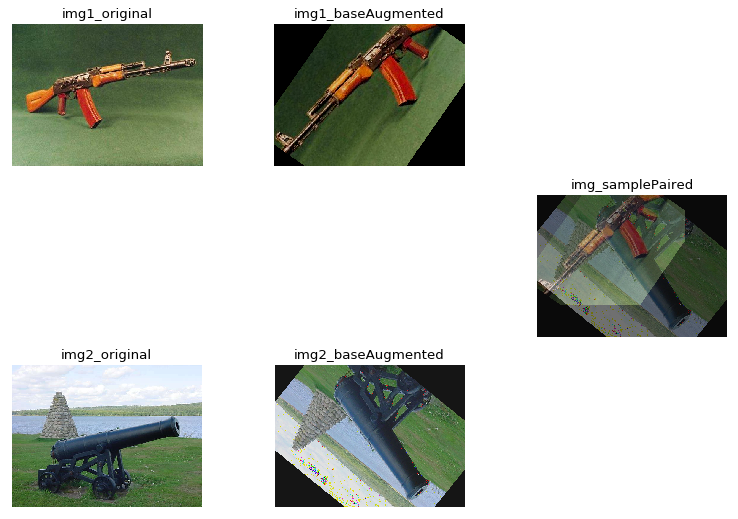

In [4]:
# 查看Sample Pairing处理图片的结果
img1 = cv2.imread("/home/aistudio/work/Images/ak47/001_0086.jpg")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread("/home/aistudio/work/Images/cannon/029_0002.jpg")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img1_baseAugmented = image_augment(img1)
img2_baseAugmented = image_augment(img2)
img_paired = samplePairing(img1_baseAugmented, img2_baseAugmented)

def erase(ax, plt):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xticks([])
    plt.yticks([])

plt.figure(figsize=(12,8),dpi=80)
#1-1
ax = plt.subplot(3, 3, 1)
plt.imshow(img1)
plt.title('img1_original')
erase(ax, plt)
#1-2
ax = plt.subplot(3, 3, 2)
plt.imshow(img1_baseAugmented)
plt.title('img1_baseAugmented')
erase(ax, plt)
#1-3
ax = plt.subplot(3, 3, 3)
plt.imshow(np.zeros(img1.shape, dtype='uint8') + 255)
erase(ax, plt)
#2-1
ax = plt.subplot(3, 3, 4)
plt.imshow(np.zeros(img_paired.shape, dtype='uint8') + 255)
erase(ax, plt)
#2-2
ax = plt.subplot(3, 3, 5)
plt.imshow(np.zeros(img_paired.shape, dtype='uint8') + 255)
erase(ax, plt)
#2-3
ax = plt.subplot(3, 3, 6)
plt.imshow(img_paired)
plt.title('img_samplePaired')
erase(ax, plt)
#3-1
ax = plt.subplot(3, 3, 7)
plt.imshow(img2)
plt.title('img2_original')
erase(ax, plt)
#3-2
ax = plt.subplot(3, 3, 8)
plt.imshow(img2_baseAugmented)
plt.title('img2_baseAugmented')
erase(ax, plt)
#3-3
ax = plt.subplot(3, 3, 9)
plt.imshow(np.zeros(img2.shape, dtype='uint8') + 255)
erase(ax, plt)

原图片img1和img2分贝经过基线的数据増广处理后按照0.5:0.5的比例逐像素叠加成一张图片，新图片的宽度为两张图片宽度的最大值，高度亦然。

# 六、Mixup

既然有了Sample Pairing这样牛叉的存在，这世上没准儿就要上演一番“瑜亮之争”。果然，Mixup半路杀出，増广的方法简直与Sample Pairing如出一辙，但更胜一筹。论文《mixup: Beyond Empirical Risk Minimization》从ERM的不足出发，理论上解释了为什么mixup可以改进模型（而Sample Pairing方法的有效原因未提出合理的解释是其论文的硬伤）。mixup是一种非常规的数据增强方法，一个和数据无关的简单数据增强原则，其以线性插值的方式来构建新的训练样本和标签，并且不止限于处理图像数据。也有观点认为这种数据増广方式实际上是一种对模型添加正则化约束的方法，也可以理解成对模型进行了剪枝。它希望模型尽可能往线性函数靠近。既保证模型预测尽可能准确，又让模型尽可能简单。结果就是，Mixup中了2018年ICLR而Sample Pairing被拒了。

Mixup的实现也十分简单，而且和Sample Pairing很像。甚至有人认为Sample Pairing可以看成是Mixup的一个特例。

![](https://ai-studio-static-online.cdn.bcebos.com/428e54d5ff9b4b1bb83d6b2d5853cf9aa8de4931bdb544ba87629958059575c6)

上图公式中的λ（既代码中的lam）为服从beta分布的位于[0,1]区间的随机数，可使用numpy库的np.random.beta(alpha, alpha)产生。其中的alpha为超参数，在本项目中取alpha=1.5。

附上论文地址：

[mixup: Beyond Empirical Risk Minimization（https://arxiv.org/abs/1710.09412）](https://arxiv.org/abs/1710.09412)

Paddle代码实现：

In [5]:
#Mix Up方式进行数据増广
import numpy as np

def mixup(img1, img2, lambd):
    h = max(img1.shape[0], img2.shape[0])
    w = max(img1.shape[1], img2.shape[1])
    img = np.zeros((h, w, img1.shape[2]), 'float32')
    img[:img1.shape[0], :img1.shape[1], :] = img1.astype('float32') * lambd
    img[:img2.shape[0], :img2.shape[1], :] += img2.astype('float32') * (1 - lambd)
    if img1.dtype == 'uint8':
        return img.astype('uint8')   # 处理、返回归一化前图片 
    else:
        return img                   # 处理、返回归一化后图片

Mixup与Sample Pairing的实现非常相似，只是用lambd参数作为比例，取代了Sample Pairing中固定的0.5:0.5比例。在训练过程中也有不同。Mixup不但将输入数据（这里是存储图片像素向量）按比例加和，而且计算loss时也是将标签（label）按比例加和在一起的。
```
# 如果选择mixup,加入mixup处理
label_mixup = []
lambd = 0
if augment == 'mixup':
    while lambd <= 0 or lambd >= 1:
        lambd = np.random.beta(1.5, 1.5) # 超参数 alpha = 1.5, beta = 1.5， lambd服从beta分布
    for i in range(x_data.shape[0]):
        img2_sn = np.random.randint(0, x_data.shape[0])
        label_mixup.append(y_data[img2_sn][0])
        x_data[i] = mixup(x_data[i], x_data[img2_sn], lambd)
    label_mixup = np.array(label_mixup).reshape(-1, 1)
                            .
                            .
                            .
loss = fluid.layers.softmax_with_cross_entropy(logits, label)
# 如果使用mixup则模型的loss也要按lambda参数的比例合成
if augment == 'mixup':
    label_mixup = fluid.dygraph.to_variable(label_mixup)
    loss_mixup = fluid.layers.softmax_with_cross_entropy(logits, label_mixup)
    loss = loss * lambd + loss_mixup * (1 - lambd)

```

下面，看看Mixup处理图片的效果：

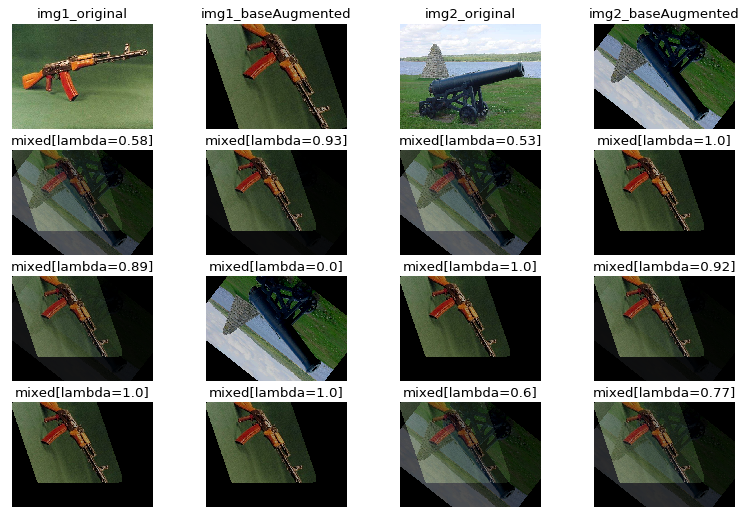

In [6]:
# 查看Mix Up处理图片的结果
img1 = cv2.imread("/home/aistudio/work/Images/ak47/001_0086.jpg")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread("/home/aistudio/work/Images/cannon/029_0002.jpg")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img1_baseAugmented = image_augment(img1)
img2_baseAugmented = image_augment(img2)
img_mixuped, img_lambd = [], []
for i in range(12):
    lambd = 0
    while lambd <= 0 or lambd >= 1:
        lambd = np.random.beta(1.5, 1.5)
    img_lambd.append(lambd)
    img_mixuped.append(mixup(img1_baseAugmented, img2_baseAugmented, lambd))

plt.figure(figsize=(12,8),dpi=80)
#1-1
ax = plt.subplot(4, 4, 1)
plt.imshow(img1)
plt.title('img1_original')
erase(ax, plt)
#1-2
ax = plt.subplot(4, 4, 2)
plt.imshow(img1_baseAugmented)
plt.title('img1_baseAugmented')
erase(ax, plt)
#1-3
ax = plt.subplot(4, 4, 3)
plt.imshow(img2)
plt.title('img2_original')
erase(ax, plt)
#1-4
ax = plt.subplot(4, 4, 4)
plt.imshow(img2_baseAugmented)
plt.title('img2_baseAugmented')
erase(ax, plt)
#2-1 ~ 4-4
for i in range(12):
    ax = plt.subplot(4, 4, 4 + i +1)
    plt.imshow(img_mixuped[i])
    plt.title('mixed[lambda='+str(round(img_lambd[i], 2))+']')
    erase(ax, plt)


原图片img1和img2分贝经过基线的数据増广处理后按照 λ:(1 - λ) 的比例逐像素叠加成一张图片，新图片的宽度为两张图片宽度的最大值，高度亦然。其中，λ为符合beta分布的随机数，beta的alpha值在本项目中取alpha=1.5。

# 七、看看这次又能涨多少点

分类模型采用了GoogleNet网络，这也是Sample Pairing论文中使用的网络。

跑之前最好先读下代码。这个模型采用Sample Pairing和Mixup方法都跑了一遍，需要时间较长。我已经跑完一遍，已经有结果输出了。各位同学也可以先跳到后面看结果。

In [ ]:
#分别使用baseline（只使用简单数据増广）、SamplePairing和MixUp三种方式训练模型，以对比效果
import numpy as np
import paddle
import paddle.fluid as fluid
from paddle.fluid.layer_helper import LayerHelper
from paddle.fluid.dygraph.nn import Conv2D, Pool2D, BatchNorm, FC
from paddle.fluid.dygraph.base import to_variable

# 数据读取
def normalize_img(img, augment=''): # 图片数据归一化
    # 将图片尺寸缩放道 224x224
    img = cv2.resize(img, (224, 224))
    # 使用自定义数据増广(包括使用samplePairing和mixup时)
    if augment == 'userDef' or augment == 'samplePairing' or augment == 'mixup':
        img = image_augment(img)
    '''
    elif augment == 'imgaugLib':  # 使用imgaug库进行数据増广
        img = image_augment_imgauglib(img)
    elif augment == 'allab':  # 使用两种方式叠加进行数据増广(先userDef后imgaugLib)
        img = image_augment_imgauglib(image_augment(img))
    elif augment == 'allba':  # 使用两种方式叠加进行数据増广(先imgaugLib后userDef)
        img = image_augment(image_augment_imgauglib(img))
    '''
    #plt.imshow(img)
    # 读入的图像数据格式是[H, W, C]。使用转置操作将其变成[C, H, W], 以适应Paddle的卷积操作对数据格式的要求
    img = np.transpose(img, (2,0,1))
    img = img.astype('float32')
    # 将数据范围调整到[-1.0, 1.0]之间
    img = img / 255.
    img = img * 2.0 - 1.0
    #img = np.mean(img, axis = 0).reshape((1, 28, 28))
    return img

def data_reader(mode='train', batch_size=8, augment=''): #定义读取器
    # 将datadir目录下的文件列出来，每条文件都要读入
    if(mode == 'train'):
        fileNames = np.loadtxt("./data/data22612/Train.txt", dtype=np.str)
        np.random.shuffle(fileNames) #只有训练集做shuffle
    elif(mode == 'validation'):
        fileNames = np.loadtxt("./data/data22612/Eval.txt", dtype=np.str)
    def reader():
        batch_imgs = []
        batch_labels = []
        for name in fileNames:
            img = cv2.imread("./work/Images/"+name[0])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if(mode == 'train'):
                img = normalize_img(img, augment) #训练集使用图像増广
            elif(mode == 'validation'):
                img = normalize_img(img) #验证集不使用图像増广
            label = name[1]
            batch_imgs.append(img)
            batch_labels.append(label)
            if len(batch_imgs) == batch_size:
                imgs_array = np.array(batch_imgs).astype('float32')
                labels_array = np.array(batch_labels).astype('int64').reshape(-1, 1)
                yield imgs_array, labels_array
                batch_imgs = []
                batch_labels = []
        if len(batch_imgs) > 0:
            imgs_array = np.array(batch_imgs).astype('float32')
            labels_array = np.array(batch_labels).astype('int64').reshape(-1, 1)
            yield imgs_array, labels_array
    return reader

# 定义VGG模型（简单好用，便于初学者理解）
# 定义vgg块，包含多层卷积和1层2x2的最大池化层
class vgg_block(fluid.dygraph.Layer):
    def __init__(self, name_scope, num_convs, num_channels):
        """
        num_convs, 卷积层的数目
        num_channels, 卷积层的输出通道数，在同一个Incepition块内，卷积层输出通道数是一样的
        """
        super(vgg_block, self).__init__(name_scope)
        self.conv_list = []
        for i in range(num_convs):
            conv_layer = self.add_sublayer('conv_' + str(i), Conv2D(self.full_name(), 
                                        num_filters=num_channels, filter_size=3, padding=1, act='relu'))
            self.conv_list.append(conv_layer)
        self.pool = Pool2D(self.full_name(), pool_stride=2, pool_size = 2, pool_type='max')
    def forward(self, x):
        for item in self.conv_list:
            x = item(x)
        return self.pool(x)

class VGG(fluid.dygraph.Layer):
    def __init__(self, name_scope, conv_arch=((2, 64), 
                                (2, 128), (3, 256), (3, 512), (3, 512)), num_classes=1):
        super(VGG, self).__init__(name_scope)
        self.vgg_blocks=[]
        iter_id = 0
        # 添加vgg_block
        # 这里一共5个vgg_block，每个block里面的卷积层数目和输出通道数由conv_arch指定
        for (num_convs, num_channels) in conv_arch:
            block = self.add_sublayer('block_' + str(iter_id), 
                    vgg_block(self.full_name(), num_convs, num_channels))
            self.vgg_blocks.append(block)
            iter_id += 1
        self.fc1 = FC(self.full_name(),
                      size=4096,
                      act='relu')
        self.drop1_ratio = 0.5
        self.fc2= FC(self.full_name(),
                      size=4096,
                      act='relu')
        self.drop2_ratio = 0.5
        self.fc3 = FC(self.full_name(),
                      size=num_classes,
                      )
    def forward(self, x):
        for item in self.vgg_blocks:
            x = item(x)
        x = fluid.layers.dropout(self.fc1(x), self.drop1_ratio)
        x = fluid.layers.dropout(self.fc2(x), self.drop2_ratio)
        x = self.fc3(x)
        return x

# GoogLeNet模型代码
import numpy as np
import paddle
import paddle.fluid as fluid
from paddle.fluid.layer_helper import LayerHelper
from paddle.fluid.dygraph.nn import Conv2D, Pool2D, BatchNorm, FC
from paddle.fluid.dygraph.base import to_variable

# 定义Inception块
class Inception(fluid.dygraph.Layer):
    def __init__(self, name_scope, c1, c2, c3, c4, **kwargs):
        '''
        Inception模块的实现代码，
        name_scope, 模块名称，数据类型为string
        c1,  图(b)中第一条支路1x1卷积的输出通道数，数据类型是整数
        c2，图(b)中第二条支路卷积的输出通道数，数据类型是tuple或list, 
               其中c2[0]是1x1卷积的输出通道数，c2[1]是3x3
        c3，图(b)中第三条支路卷积的输出通道数，数据类型是tuple或list, 
               其中c3[0]是1x1卷积的输出通道数，c3[1]是3x3
        c4,  图(b)中第一条支路1x1卷积的输出通道数，数据类型是整数
        '''
        super(Inception, self).__init__(name_scope)
        # 依次创建Inception块每条支路上使用到的操作
        self.p1_1 = Conv2D(self.full_name(), num_filters=c1, 
                           filter_size=1, act='relu')
        self.p2_1 = Conv2D(self.full_name(), num_filters=c2[0], 
                           filter_size=1, act='relu')
        self.p2_2 = Conv2D(self.full_name(), num_filters=c2[1], 
                           filter_size=3, padding=1, act='relu')
        self.p3_1 = Conv2D(self.full_name(), num_filters=c3[0], 
                           filter_size=1, act='relu')
        self.p3_2 = Conv2D(self.full_name(), num_filters=c3[1], 
                           filter_size=5, padding=2, act='relu')
        self.p4_1 = Pool2D(self.full_name(), pool_size=3, 
                           pool_stride=1,  pool_padding=1, 
                           pool_type='max')
        self.p4_2 = Conv2D(self.full_name(), num_filters=c4, 
                           filter_size=1, act='relu')

    def forward(self, x):
        # 支路1只包含一个1x1卷积
        p1 = self.p1_1(x)
        # 支路2包含 1x1卷积 + 3x3卷积
        p2 = self.p2_2(self.p2_1(x))
        # 支路3包含 1x1卷积 + 5x5卷积
        p3 = self.p3_2(self.p3_1(x))
        # 支路4包含 最大池化和1x1卷积
        p4 = self.p4_2(self.p4_1(x))
        # 将每个支路的输出特征图拼接在一起作为最终的输出结果
        return fluid.layers.concat([p1, p2, p3, p4], axis=1)  
    
class GoogLeNet(fluid.dygraph.Layer):
    def __init__(self, name_scope, num_classes=1):
        super(GoogLeNet, self).__init__(name_scope)
        # GoogLeNet包含五个模块，每个模块后面紧跟一个池化层
        # 第一个模块包含1个卷积层
        self.conv1 = Conv2D(self.full_name(), num_filters=64, filter_size=7, 
                            padding=3, act='relu')
        # 3x3最大池化
        self.pool1 = Pool2D(self.full_name(), pool_size=3, pool_stride=2,  
                            pool_padding=1, pool_type='max')
        # 第二个模块包含2个卷积层
        self.conv2_1 = Conv2D(self.full_name(), num_filters=64, 
                              filter_size=1, act='relu')
        self.conv2_2 = Conv2D(self.full_name(), num_filters=192, 
                              filter_size=3, padding=1, act='relu')
        # 3x3最大池化
        self.pool2 = Pool2D(self.full_name(), pool_size=3, pool_stride=2,  
                            pool_padding=1, pool_type='max')
        # 第三个模块包含2个Inception块
        self.block3_1 = Inception(self.full_name(), 64, (96, 128), (16, 32), 32)
        self.block3_2 = Inception(self.full_name(), 128, (128, 192), (32, 96), 64)
        # 3x3最大池化
        self.pool3 = Pool2D(self.full_name(), pool_size=3, pool_stride=2,  
                               pool_padding=1, pool_type='max')
        # 第四个模块包含5个Inception块
        self.block4_1 = Inception(self.full_name(), 192, (96, 208), (16, 48), 64)
        self.block4_2 = Inception(self.full_name(), 160, (112, 224), (24, 64), 64)
        self.block4_3 = Inception(self.full_name(), 128, (128, 256), (24, 64), 64)
        self.block4_4 = Inception(self.full_name(), 112, (144, 288), (32, 64), 64)
        self.block4_5 = Inception(self.full_name(), 256, (160, 320), (32, 128), 128)
        # 3x3最大池化
        self.pool4 = Pool2D(self.full_name(), pool_size=3, pool_stride=2,  
                               pool_padding=1, pool_type='max')
        # 第五个模块包含2个Inception块
        self.block5_1 = Inception(self.full_name(), 256, (160, 320), (32, 128), 128)
        self.block5_2 = Inception(self.full_name(), 384, (192, 384), (48, 128), 128)
        # 全局池化，尺寸用的是global_pooling，pool_stride不起作用
        self.pool5 = Pool2D(self.full_name(), pool_stride=1, 
                               global_pooling=True, pool_type='avg')
        self.fc = FC(self.full_name(),  size=num_classes)

    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2_2(self.conv2_1(x)))
        x = self.pool3(self.block3_2(self.block3_1(x)))
        x = self.block4_3(self.block4_2(self.block4_1(x)))
        x = self.pool4(self.block4_5(self.block4_4(x)))
        x = self.pool5(self.block5_2(self.block5_1(x)))
        x = self.fc(x)
        return x

# 模型训练
# 定义训练过程
def train(model, augment=''):
    with fluid.dygraph.guard():
        print('start training ... ')
        model.train()
        epoch_num = 500
        sample_pairing_start_epoch = int(epoch_num / 10)
        sample_pairing_end_epoch = epoch_num - sample_pairing_start_epoch
        BATCH_SIZE = 8
        opt = fluid.optimizer.AdamOptimizer(learning_rate=0.0001)
        # opt = fluid.optimizer.MomentumOptimizer(learning_rate=0.001, momentum=0.9)
        train_loader = data_reader(mode='train', batch_size=BATCH_SIZE, augment=augment)
        valid_loader = data_reader(mode='validation', batch_size=BATCH_SIZE, augment=augment)
        lossTrain, accTrain, lossEval, accEval = [], [], [], []
        bestPrecise = 0
        for epoch in range(epoch_num):
            lossEpochMean = 0
            accEpochMean = 0
            for batch_id, data in enumerate(train_loader()):
                x_data, y_data = data
                # 如果选择samplePairing,在设定的epoch范围内进行samplePairing处理,每10次间歇性禁用2次。
                if augment == 'samplePairing' and epoch >= sample_pairing_start_epoch \
                    and epoch < sample_pairing_end_epoch and epoch % 10 < 8:
                    for i in range(x_data.shape[0]):
                        x_data[i] = samplePairing(x_data[i], x_data[np.random.randint(0, x_data.shape[0])])
                # 如果选择mixup,加入mixup处理
                label_mixup = []
                lambd = 0
                if augment == 'mixup':
                    while lambd <= 0 or lambd >= 1:
                        lambd = np.random.beta(1.5, 1.5) # 超参数 alpha = 1.5, beta = 1.5， lambd服从beta分布
                    for i in range(x_data.shape[0]):
                        img2_sn = np.random.randint(0, x_data.shape[0])
                        label_mixup.append(y_data[img2_sn][0])
                        x_data[i] = mixup(x_data[i], x_data[img2_sn], lambd)
                    label_mixup = np.array(label_mixup).reshape(-1, 1)
                # 将numpy.ndarray转化成Tensor
                img = fluid.dygraph.to_variable(x_data)
                label = fluid.dygraph.to_variable(y_data)
                # 计算模型输出
                logits = model(img)
                pred = fluid.layers.softmax(logits)
                #print(label.numpy().T)
                # 计算损失函数
                loss = fluid.layers.softmax_with_cross_entropy(logits, label)
                # 如果使用mixup则模型的loss也要按lambda参数的比例合成
                if augment == 'mixup':
                    label_mixup = fluid.dygraph.to_variable(label_mixup)
                    loss_mixup = fluid.layers.softmax_with_cross_entropy(logits, label_mixup)
                    loss = loss * lambd + loss_mixup * (1 - lambd)
                avg_loss = fluid.layers.mean(loss)
                lossEpochMean += avg_loss.numpy()[0]
                acc = fluid.layers.accuracy(pred, label)
                accEpochMean += acc.numpy()[0]
                avg_loss.backward()
                opt.minimize(avg_loss)
                model.clear_gradients()
            lossEpochMean = lossEpochMean / (batch_id+1)
            accEpochMean = accEpochMean / (batch_id+1)
            lossTrain.append(lossEpochMean)
            accTrain.append(accEpochMean)
            print("epoch: {}, loss is: {}, acc is: {}".format(epoch, [lossEpochMean], [accEpochMean]))

            model.eval()
            lossEpochMean2 = 0
            accEpochMean2 = 0
            for batch_id2, data2 in enumerate(valid_loader()):
                x_data2, y_data2 = data2
                # 将numpy.ndarray转化成Tensor
                img2 = fluid.dygraph.to_variable(x_data2)
                label2 = fluid.dygraph.to_variable(y_data2)
                # 计算模型输出
                logits2 = model(img2)
                pred2 = fluid.layers.softmax(logits2)
                #print(label2.numpy().T)
                # 计算损失函数
                loss2 = fluid.layers.softmax_with_cross_entropy(logits2, label2)
                avg_loss2 = fluid.layers.mean(loss2)
                lossEpochMean2 += avg_loss2.numpy()[0]
                acc2 = fluid.layers.accuracy(pred2, label2)
                accEpochMean2 += acc2.numpy()[0]
            lossEpochMean2 = lossEpochMean2 / (batch_id2+1)
            accEpochMean2 = accEpochMean2 / (batch_id2+1)
            lossEval.append(lossEpochMean2)
            accEval.append(accEpochMean2)
            print("[validation] loss/accuracy: {}/{}".format(lossEpochMean2, accEpochMean2))
            model.train()
        
        if augment == 'userDef': # 使用自定义数据増广
            graphSavePath = './logs/userDefAug_'
        elif augment == 'imgaugLib':  # 使用imgaug库进行数据増广
            graphSavePath = './logs/imgaugLibAug_'
        elif augment == 'allab':  # 使用imgaug库进行数据増广
            graphSavePath = './logs/allabAug_'
        elif augment == 'allba':  # 使用imgaug库进行数据増广
            graphSavePath = './logs/allbaAug_'
        elif augment == 'samplePairing':  # 使用samplePairing
            graphSavePath = './logs/samplePairingAug_'
        elif augment == 'mixup':  # 使用mixup
            graphSavePath = './logs/mixupAug_'
        else: #不使用数据増广
            graphSavePath = './logs/noAug_'
        np.save(graphSavePath+"lossTrain.npy", np.array(lossTrain))
        np.save(graphSavePath+"accTrain.npy", np.array(accTrain))
        np.save(graphSavePath+"lossEval.npy", np.array(lossEval))
        np.save(graphSavePath+"accEval.npy", np.array(accEval))
        #print(lossTrain, accTrain, lossEval, accEval)
        print('graphs saved...')
        print('end...')

if __name__ == '__main__':
    # 创建模型
    #model = LeNet("LeNet", num_classes=16)
    #model = AlexNet("AlexNet", num_classes=16)
    #model = VGG("VGG", num_classes=16)
    #model = GoogLeNet("GoogLeNet", num_classes=16)
    #model = ResNet("ResNet", class_dim=16)
    #model = ResNet("ResNet", class_dim=16, layers=101)
    #model = ResNet("ResNet", class_dim=16, layers=152)
    #启动训练过程

    # train(model) # 不使用数据増广的训练
    # model = VGG("VGG", num_classes=16) # 重新初始化网络权重参数
    # train(model, augment='userDef') # 使用自定义数据増广的训练
    # model = VGG("VGG", num_classes=16)
    # train(model, augment='imgaugLib') # 使用imgaug库进行数据増广的训练
    # model = VGG("VGG", num_classes=16)
    # train(model, augment='allab') # 使用两种方式进叠加行数据増广的训练(先userDef后imgaugLib)
    # model = VGG("VGG", num_classes=16)
    # train(model, augment='allba') # 使用两种方式叠加进行数据増广的训练(先imgaugLib后userDef)
    # model = VGG("VGG", num_classes=16)
    # train(model, augment='samplePairing') # 使用samplePairing
    # model = VGG("VGG", num_classes=16)
    # train(model, augment='mixup') # 使用mixup

    # model = GoogLeNet("GoogLeNet", num_classes=16)
    # train(model, augment='userDef') # 使用自定义数据増广的训练
    model = GoogLeNet("GoogLeNet", num_classes=16)
    train(model, augment='samplePairing') # 使用samplePairing
    model = GoogLeNet("GoogLeNet", num_classes=16)
    train(model, augment='mixup') # 使用mixup
   


让我们看看分别用了 Sample Pairing 和 Mixup 进行数据増广后与基线版本的比较。

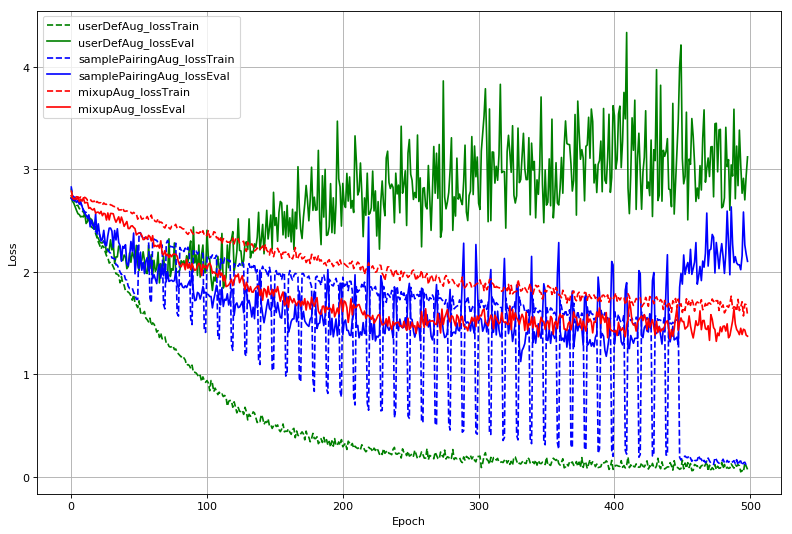

In [15]:
#查看训练结果(loss)
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
figurePath = "./logs/"
start = 400 # 查看最后100epoch
start = 0
end = -1
userDefAug_lossTrain = np.load(figurePath+"userDefAug_lossTrain.npy")[start:end]
userDefAug_lossEval = np.load(figurePath+"userDefAug_lossEval.npy")[start:end]
samplePairingAug_lossTrain = np.load(figurePath+"samplePairingAug_lossTrain.npy")[start:end]
samplePairingAug_lossEval = np.load(figurePath+"samplePairingAug_lossEval.npy")[start:end]
mixupAug_lossTrain = np.load(figurePath+"mixupAug_lossTrain.npy")[start:end]
mixupAug_lossEval = np.load(figurePath+"mixupAug_lossEval.npy")[start:end]
plt.figure(figsize=(12,8),dpi=80)
plt.plot(range(len(userDefAug_lossTrain)), userDefAug_lossTrain, 'g--', label='userDefAug_lossTrain')
plt.plot(range(len(userDefAug_lossEval)), userDefAug_lossEval, 'g', label='userDefAug_lossEval')
plt.plot(range(len(samplePairingAug_lossTrain)), samplePairingAug_lossTrain, 'b--', label='samplePairingAug_lossTrain')
plt.plot(range(len(samplePairingAug_lossEval)), samplePairingAug_lossEval, 'b', label='samplePairingAug_lossEval')
plt.plot(range(len(mixupAug_lossTrain)), mixupAug_lossTrain, 'r--', label='mixupAug_lossTrain')
plt.plot(range(len(mixupAug_lossEval)), mixupAug_lossEval, 'r', label='mixupAug_lossEval')
plt.legend(loc="upper left")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

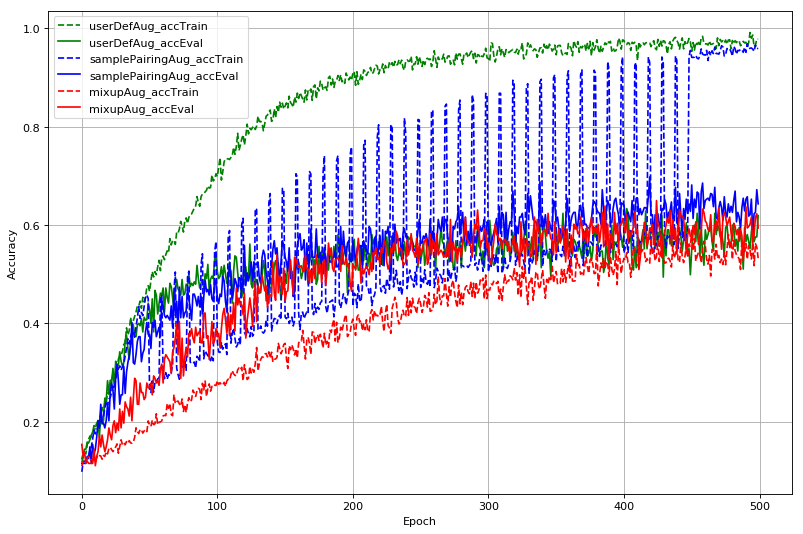

In [20]:
#查看训练结果(Accuracy)
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
figurePath = "./logs/"
start = 400 # 查看最后100epoch
start = 0
end = 500

userDefAug_accTrain = np.load(figurePath+"userDefAug_accTrain.npy")[start:end]
userDefAug_accEval = np.load(figurePath+"userDefAug_accEval.npy")[start:end]
samplePairingAug_accTrain = np.load(figurePath+"samplePairingAug_accTrain.npy")[start:end]
samplePairingAug_accEval = np.load(figurePath+"samplePairingAug_accEval.npy")[start:end]
mixupAug_accTrain = np.load(figurePath+"mixupAug_accTrain.npy")[start:end]
mixupAug_accEval = np.load(figurePath+"mixupAug_accEval.npy")[start:end]
plt.figure(figsize=(12,8),dpi=80)
plt.plot(range(len(userDefAug_accTrain)), userDefAug_accTrain, 'g--', label='userDefAug_accTrain')
plt.plot(range(len(userDefAug_accEval)), userDefAug_accEval, 'g', label='userDefAug_accEval')
plt.plot(range(len(samplePairingAug_accTrain)), samplePairingAug_accTrain, 'b--', label='samplePairingAug_accTrain')
plt.plot(range(len(samplePairingAug_accEval)), samplePairingAug_accEval, 'b', label='samplePairingAug_accEval')
plt.plot(range(len(mixupAug_accTrain)), mixupAug_accTrain, 'r--', label='mixupAug_accTrain')
plt.plot(range(len(mixupAug_accEval)), mixupAug_accEval, 'r', label='mixupAug_accEval')
plt.legend(loc="upper left")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()
# print(userDefAug_lossTrain[-10:-1].mean(),userDefAug_lossEval[-10:-1].mean(),samplePairingAug_lossTrain[-10:-1].mean(),\
#     samplePairingAug_lossEval[-10:-1].mean(),mixupAug_lossTrain[-10:-1].mean(),mixupAug_lossEval[-10:-1].mean())
# print(userDefAug_accTrain[-10:-1].mean(),userDefAug_accEval[-10:-1].mean(),samplePairingAug_accTrain[-10:-1].mean(),\
#     samplePairingAug_accEval[-10:-1].mean(),mixupAug_accTrain[-10:-1].mean(),mixupAug_accEval[-10:-1].mean())   

上面的两幅折线图中，第一幅画的是loss曲线，第二副画的的accuracy（准确率）曲线；绿色线为基线版本的曲线，蓝线Sample Pairing版本的，红线是Mixup版本的；虚线是训练集曲线，实线是验证集曲线。

绿色线代表的基线版本（只采用了拉伸、旋转、颜色、清晰度、加噪等几种简单的数据増广方法）的曲线早早就显示出模型过拟合了。loss曲线“上下大劈叉”，验证集的accuracy曲线早早就追不上训练集曲线的“凤舞九天”，这些都是过拟合的典型症状。

蓝色线代表的加Sample Pairing处理版本的训练集曲线震动的幅度“大而整齐”，这是间歇性停用Sample Pairing处理造成的。在模型开始训练的前1/10和即将结束的最后1/10epoch中没有启用用Sample Pairing处理，所以那时的训练曲线就没有震动幅度“大而整齐”的现象。纵观所有训练epoch，从大概150epoch开始，绿色实现开始运动到红色曲线的上方，也是说从那时开始其验证集的准确率已经开始超过基线版本。

红色曲线代表的加Mixup处理版本的loss曲线开始时下降慢，accuracy（准确率）曲线开始时上升也慢。这是因为，我们从模型一开始训练就加入了Mixup操作。从前面实验各种数据増广时的情况看，在训练集加越多的増广处理，模型训练的初期，loss曲线的下降越慢（acc曲线上上升也越慢）。在模型训练大概250epoch左右后，加Mixup处理的模型的accuracy曲线开始向上超越基线版本的曲线。

为了展示模型在三种条件下训练500epoch后分类精度的提升情况，我们将模型训练的最终数据汇总于下表。由于模型准确率曲线震动幅度较大，我们分别取各条曲线最后10个数值的平均值作为参考值。

![](https://ai-studio-static-online.cdn.bcebos.com/3878dd5324064643a4dc4e4cae9ce99a186c1ba1d6714fc8a803dc14d624b7c1)

从实验结果看，这个项目采用Sample Pairing方法时精度提高了6个点，采用Mixup方法时提高了3个点左右。等等，项目前面不是说Mixup是比Sample Pairing更牛叉的存在么（ICLR不也同意么）？怎么这里Mixup效果还不如Sample Pairing？我的想法是“丹得亲自炼，方得自己选”，没哪个方法一定在所有情况下都是最好的，诸葛两也不是次次都赢周瑜，赤壁其实是周瑜烧的，没诸葛亮啥事，但考试答题时还是得答...当然得看是历史考试还是语文考试...

总之，今天我们项目里介绍的这两种“双打”的图像増广技术比（上）文中介绍的技术更加强大，再次驯服了模型的过拟合。在训练了500epoch后，采用了Sample Pairing和Mixup的模型也没有出现过拟合的迹象，而且还获得了不小的分类精度提升。

最后再来个“穿帮镜头的片花”，。

下面的折线图是我用VGGNet模型做上面实验的结果。当时我以为在（比Sample Pairing论文中提到的GoogleNet）效率稍低点的模型上实验能取得更加显著的效果，便于展示（也基于同样的原因，我没有在模型中添加正则化项以控制夸张的过拟合）。没想到结果竟是这样的...


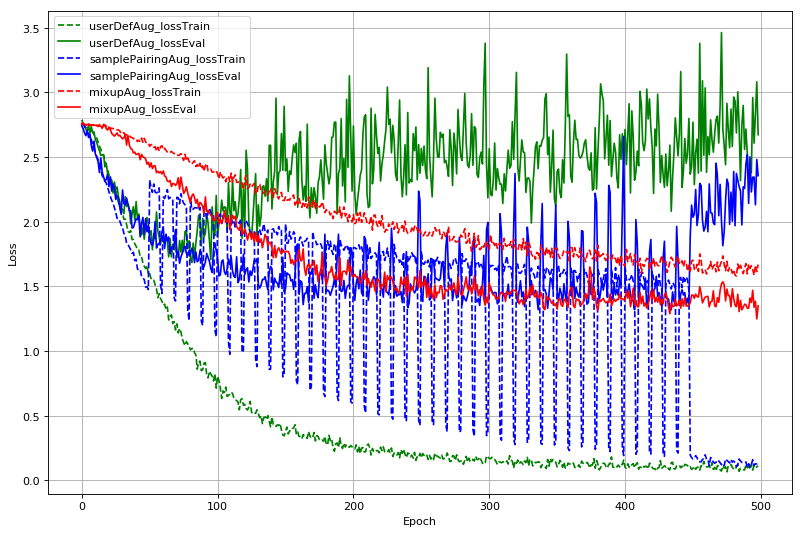

In [7]:
#查看采用VGGNet训练结果(loss)
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
figurePath = "./logs_vggnet/"
start = 400 # 查看最后100epoch
start = 0
end = -1
userDefAug_lossTrain = np.load(figurePath+"userDefAug_lossTrain.npy")[start:end]
userDefAug_lossEval = np.load(figurePath+"userDefAug_lossEval.npy")[start:end]
samplePairingAug_lossTrain = np.load(figurePath+"samplePairingAug_lossTrain.npy")[start:end]
samplePairingAug_lossEval = np.load(figurePath+"samplePairingAug_lossEval.npy")[start:end]
mixupAug_lossTrain = np.load(figurePath+"mixupAug_lossTrain.npy")[start:end]
mixupAug_lossEval = np.load(figurePath+"mixupAug_lossEval.npy")[start:end]
plt.figure(figsize=(12,8),dpi=80)
plt.plot(range(len(userDefAug_lossTrain)), userDefAug_lossTrain, 'g--', label='userDefAug_lossTrain')
plt.plot(range(len(userDefAug_lossEval)), userDefAug_lossEval, 'g', label='userDefAug_lossEval')
plt.plot(range(len(samplePairingAug_lossTrain)), samplePairingAug_lossTrain, 'b--', label='samplePairingAug_lossTrain')
plt.plot(range(len(samplePairingAug_lossEval)), samplePairingAug_lossEval, 'b', label='samplePairingAug_lossEval')
plt.plot(range(len(mixupAug_lossTrain)), mixupAug_lossTrain, 'r--', label='mixupAug_lossTrain')
plt.plot(range(len(mixupAug_lossEval)), mixupAug_lossEval, 'r', label='mixupAug_lossEval')
plt.legend(loc="upper left")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

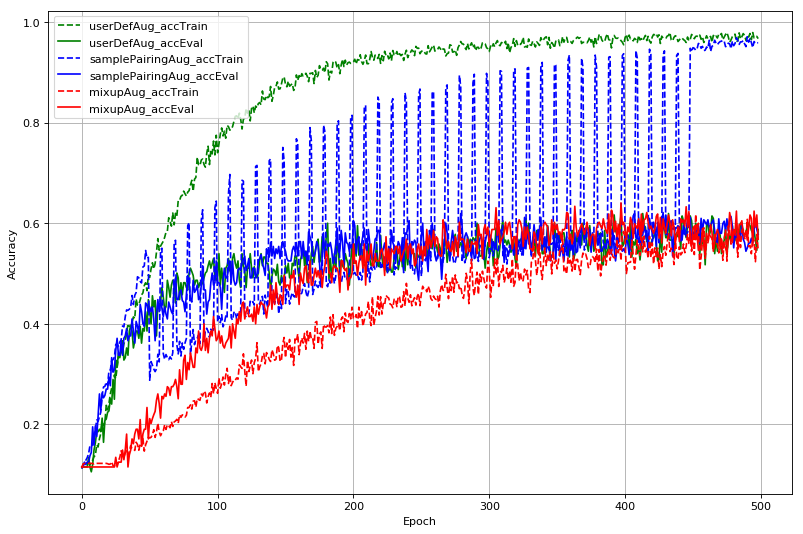

In [10]:
#查看采用VGGNet训练结果(Accuracy)
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
figurePath = "./logs_vggnet/"
start = 400 # 查看最后100epoch
start = 0
end = -1

userDefAug_accTrain = np.load(figurePath+"userDefAug_accTrain.npy")[start:end]
userDefAug_accEval = np.load(figurePath+"userDefAug_accEval.npy")[start:end]
samplePairingAug_accTrain = np.load(figurePath+"samplePairingAug_accTrain.npy")[start:end]
samplePairingAug_accEval = np.load(figurePath+"samplePairingAug_accEval.npy")[start:end]
mixupAug_accTrain = np.load(figurePath+"mixupAug_accTrain.npy")[start:end]
mixupAug_accEval = np.load(figurePath+"mixupAug_accEval.npy")[start:end]
plt.figure(figsize=(12,8),dpi=80)
plt.plot(range(len(userDefAug_accTrain)), userDefAug_accTrain, 'g--', label='userDefAug_accTrain')
plt.plot(range(len(userDefAug_accEval)), userDefAug_accEval, 'g', label='userDefAug_accEval')
plt.plot(range(len(samplePairingAug_accTrain)), samplePairingAug_accTrain, 'b--', label='samplePairingAug_accTrain')
plt.plot(range(len(samplePairingAug_accEval)), samplePairingAug_accEval, 'b', label='samplePairingAug_accEval')
plt.plot(range(len(mixupAug_accTrain)), mixupAug_accTrain, 'r--', label='mixupAug_accTrain')
plt.plot(range(len(mixupAug_accEval)), mixupAug_accEval, 'r', label='mixupAug_accEval')
plt.legend(loc="upper left")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

当我用VGG模型在GPU跑了1天半就得出上面这一坨准确率曲线时，真是满头大汗。这个结果根本看不出用了SamplePairing和Mixup后有任何准确率上的改善，这让我怎么圆场...我总不能无良的把曲线从400epoch截断，然后勉强的说Mixup总算还有点用吧。所以，我果断决定以“采用更好的模型GoogleNet”、“填加L2正则化项”、“添加dropout层”等操作泡制新的测试环境，直到做出“令同学们满意的”结果为止。然后，就有了前面正文里那个“还算说得过去”的结果。当然，我也并不觉得这种行为比“从400epoch截断”高尚多少。但这个项目的重点并不是小弟的“人品”，毕竟论文不是我写的，mixup满大街都在用。通过这个项目我想说的是，任何的方法都不是万灵丹，只有在合适的条件下才能发挥作用。比如，大伙儿在应用mixup时一般也不会全程使用，后期精调（finetune）时都是要把各种数据増广处理去掉的。采众家之长，才是我辈炼丹的奥义。

可见，要复现“天花乱坠”的论文结果也不是都能一气呵成的。除了靠“人品”，还要有点儿修为（技术），至少要有“一顿操作猛如虎”觉悟。谁能保证像Sample Pairing、Mixup这样的技术不是“大力出奇迹”的产物呢？哇哈哈哈。

【未完待续：下次玩玩SMOTE方法进行増广】

PS.后来我查阅论文时发现，文中Mixup方法的超参数alpha的取值范围应为[0.1,0.4]，取值过大可能会导致模型欠拟合。本项目中alpha取值为1.5，也可能过大了。这也可能是为什么其效果不如Sample Pairing的原因吧。alpha的取值是因项目而异的。


本人主要方向是深度学习技术在媒体、教育上的应用。欢迎深度学习赛道上的新老司机们关注交流，以后还会为大家分享更多有趣的项目。

【下面是我的主页链接】

来AI Studio互粉吧~等你哦~ [https://aistudio.baidu.com/aistudio/personalcenter/thirdview/76563](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/76563)

【项目列表】

[训练数据太少？过拟合？一文带你领略“数据增长魔法”(上) (https://aistudio.baidu.com/aistudio/projectdetail/408059)](https://aistudio.baidu.com/aistudio/projectdetail/408059)

[训练数据太少？过拟合？一文带你领略“数据增长魔法”(下) (https://aistudio.baidu.com/aistudio/projectdetail/422256)](https://aistudio.baidu.com/aistudio/projectdetail/422256)

[一文帮你理解用Paddle训练模型的原理1-手写回归模型 (https://aistudio.baidu.com/aistudio/projectdetail/367090)](https://aistudio.baidu.com/aistudio/projectdetail/367090)

[一文帮你理解用Paddle训练模型的原理2-权值可视化（VisualDL） (https://aistudio.baidu.com/aistudio/projectdetail/386954)](https://aistudio.baidu.com/aistudio/projectdetail/386954)

